# TOPIC MODELING OF CELEBRITY TWEETS

Dataset source: https://www.kaggle.com/speckledpingu/RawTwitterFeeds

R Notebook: https://www.kaggle.com/donyoe/famous-people-twitter-analisys

### Related topics:
https://www.analyticsvidhya.com/blog/2017/10/essential-nlp-guide-data-scientists-top-10-nlp-tasks/

https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed

### IMPORT PACKAGES

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
#from sklearn.grid_search import GridSearchCV
%matplotlib inline

In [2]:
mydata = pd.read_csv("alltweets.csv")
mydata = mydata.sample(n=20000) # we take a sample because of capacity concerns
print(mydata.columns, mydata.shape)
mydata.head(10)

Index(['Unnamed: 0', 'Unnamed: 0.1', 'date', 'id', 'link', 'retweet', 'text',
       'author', 'author_num'],
      dtype='object') (20000, 9)


Unnamed: 0  Unnamed: 0.1        date            id  \
28733       15615         15615   9/17/2012  2.477820e+17   
9184         4312          4312   8/27/2012  2.401640e+17   
35937        4517          4517   1/29/2020  6.932120e+17   
24774       10578         10578   5/24/2013  3.380210e+17   
63890        8673          8673   7/28/2011  9.656560e+16   
5629          757           757   6/26/2015  6.144590e+17   
20228        6032          6032   11/5/2014  5.299620e+17   
39635        8223          8223  11/19/2014  5.351560e+17   
80451        2266          2266   8/16/2020  7.656830e+17   
57071        1606          1606  11/13/2015  6.652590e+17   

                                             link  retweet  \
28733  /realDonaldTrump/status/247781944497147904    False   
9184       /BarackObama/status/240163862341640192    False   
35937  /FiveThirtyEight/status/693212295967567872    False   
24774  /realDonaldTrump/status/338021165052334080     True   
63890              /NASA/status/96565569297465345    False   
5629       /BarackObama/status/614459251126173697    False   
20228  /realDonaldTrump/status/529962203550875648     True   
39635  /FiveThirtyEight/status/535155510698573824    False   
80451        /esimoudis/status/765682952835444736    False   
57071             /NASA/status/665259091061772288    False   

                                                    text           author  \
28733  Ugly wind turbines have destroyed the entrance...      DonaldTrump   
9184   Make it easier for the people who want to see ...      BarackObama   
35937  The tennis court is a laboratory for innovatio...  FiveThirtyEight   
24774  "@brandongersh: @realDonaldTrump Why did you g...      DonaldTrump   
63890  Only 3 hrs left to register for #NASATweetup f...             NASA   
5629   Retweet to spread the word. #LoveWinspic.twitt...      BarackObama   
20228  "@zedd_tahlz: Can't wait for the new season of...      DonaldTrump   
39635  The Supreme Court won’t be getting another Son...  FiveThirtyEight   
80451  @usamaf @kdnuggets but we've all created big $...          various   
57071  It’s Friday the 13th, and here are 13 reasons ...             NASA   

       author_num  
28733           4  
9184            2  
35937           5  
24774           4  
63890           8  
5629            2  
20228           4  
39635           5  
80451          11  
57071           8

In [3]:
# Drop the unnecessary columns
# Note: you can only run it once without an error
mydata = mydata.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
mydata.head(5)

date            id                                        link  \
28733  9/17/2012  2.477820e+17  /realDonaldTrump/status/247781944497147904   
9184   8/27/2012  2.401640e+17      /BarackObama/status/240163862341640192   
35937  1/29/2020  6.932120e+17  /FiveThirtyEight/status/693212295967567872   
24774  5/24/2013  3.380210e+17  /realDonaldTrump/status/338021165052334080   
63890  7/28/2011  9.656560e+16              /NASA/status/96565569297465345   

       retweet                                               text  \
28733    False  Ugly wind turbines have destroyed the entrance...   
9184     False  Make it easier for the people who want to see ...   
35937    False  The tennis court is a laboratory for innovatio...   
24774     True  "@brandongersh: @realDonaldTrump Why did you g...   
63890    False  Only 3 hrs left to register for #NASATweetup f...   

                author  author_num  
28733      DonaldTrump           4  
9184       BarackObama           2  
35937  FiveThirtyEight           5  
24774      DonaldTrump           4  
63890             NASA           8

In [4]:
mydata["date"].describe()

count         20000
unique         2873
top       7/27/2020
freq             50
Name: date, dtype: object

### Some notes about datetime

In [5]:
#Convert date to datetime
mydata["date"] = mydata["date"].astype("datetime64", errors='ignore')
mydata["date"].head()

28733   2012-09-17
9184    2012-08-27
35937   2020-01-29
24774   2013-05-24
63890   2011-07-28
Name: date, dtype: datetime64[ns]

In [6]:
df1 = mydata.groupby(mydata['date'].dt.date).size().reset_index(name='Count')
print(df1.columns, df1.shape)

Index(['date', 'Count'], dtype='object') (2873, 2)


C:\Users\carly\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<BarContainer object of 2873 artists>

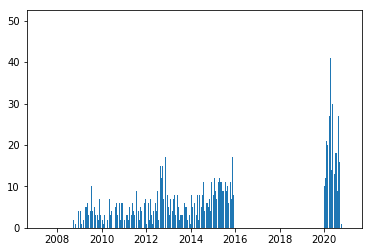

In [7]:
# Frequency of tweets over time
plt.bar(df1["date"], df1["Count"])

#### How can we double check the above results? 

In [8]:
print(mydata["author"].value_counts())

DonaldTrump        3908
NASA               3680
KimKardashian      2439
various            2325
FiveThirtyEight    2186
BarackObama        1537
RichardDawkins     1349
AdamSavage         1035
HillaryClinton      713
deGrasseTyson       541
ScottKelly          287
Name: author, dtype: int64


In [9]:
print(mydata["retweet"].value_counts())

False    19203
True       797
Name: retweet, dtype: int64


In [10]:
mydata.columns

Index(['date', 'id', 'link', 'retweet', 'text', 'author', 'author_num'], dtype='object')

### Text Preprocessing

We want the text to be processable and analyzable. Therefore, we should standardize how the text is processed. See the comments below to see what each row does to the text.

In [11]:
import re

def clean_text(string_in):
    string_in = re.sub(r"@\w+", "", string_in) # Remove twitter handle
    string_in = re.sub(r"\d", "", string_in) # Remove numbers  
    string_in = re.sub(r"_+", "", string_in) # Remove consecutive underscores
    string_in = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', string_in) # remove URLs
    string_in = string_in.lower() # Tranform to lower case    
    string_in = re.sub('@[^\s]+', 'AT_USER', string_in) # remove usernames
    string_in = re.sub(r'#([^\s]+)', r'\1', string_in) # remove the # in #hashtag
    return string_in.strip()

mydata["tweet_text_cleaned"] = mydata.text.apply(clean_text)
print(mydata["tweet_text_cleaned"])

28733    ugly wind turbines have destroyed the entrance...
9184     make it easier for the people who want to see ...
35937    the tennis court is a laboratory for innovatio...
24774    ":  why did you go to wharton did you not get ...
63890    only  hrs left to register for nasatweetup for...
5629     retweet to spread the word. lovewinspic.twitte...
20228    ": can't wait for the new season of celebritya...
39635    the supreme court won’t be getting another son...
80451    but we've all created big $ returns for our lp...
57071    it’s friday the th, and here are  reasons to m...
88271    peering into the blackbox & explainability  bi...
28199    obama keeps saying that he will do something--...
56608    on christmas, your belly won’t be the only thi...
52647    golfing in paris! this is unreal! i'm a better...
58909    not able to join us for our  mission documenta...
45651    wearing yeezy season leggings, bodysuit, coat ...
56869    new launch time for cygnus is sun, dec  at :p .

## TOKENIZATION

Short example of tokenization: ['The quick lazy fox jumps over the brown fence'] --> ['The', 'quick', 'lazy', 'fox', 'jumps', 'over', 'the', 'brown', 'fence']

In [12]:
from nltk.tokenize import RegexpTokenizer
preprocessed = [" ".join(RegexpTokenizer(r'\w+').\
                         tokenize(mydata.tweet_text_cleaned[idx])) \
                for idx in mydata.index]
print(preprocessed)

['ugly wind turbines have destroyed the entrance to palm springs ca these monstrosities are ruining landscapes cont url', 'make it easier for the people who want to see the president s birth certificate get it on a button url', 'the tennis court is a laboratory for innovation url pic twitter com dufgcylu', 'why did you go to wharton did you not get into harvard wharton is better for business than harvard', 'only hrs left to register for nasatweetup for grail launch to the moon sept url', 'retweet to spread the word lovewinspic twitter com jjicpzwn', 'can t wait for the new season of celebrityapprentice its gonna be epic great cast selection', 'the supreme court won t be getting another sonia sotomayor anytime soon url pic twitter com xybwfevsh', 'but we ve all created big returns for our lp through our startup liquidityevents', 'it s friday the th and here are reasons to make it out of this world check it out url pic twitter com ntzyquhh', 'peering into the blackbox explainability bigd

### nltk documentation

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 

custom_stop_words = []
my_stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop_words)

vectorizer = TfidfVectorizer(min_df = 1, ngram_range = (1,1), 
                             stop_words = my_stop_words)

tfidf = vectorizer.fit_transform(preprocessed)
print("Created document-term matrix of size %d x %d" % (tfidf.shape[0],tfidf.shape[1]))

Created document-term matrix of size 20000 x 24609


### TOPIC MODELING

Choose the number of top words you want to look at, and choose the number of topics. 

#### In the code below, can you find where to change these?

In [14]:
from sklearn import decomposition
import numpy as np
nmf = decomposition.NMF(init = 'nndsvd', n_components = 3, max_iter = 200)
W = nmf.fit_transform(tfidf)
H = nmf.components_
print("Generated factor W of size %s and factor H of size %s" % ( str(W.shape), str(H.shape)))

feature_names = vectorizer.get_feature_names()
n_top_words = 15 

# Print top words in each topic
for topic_idx, topic in enumerate(H):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Generated factor W of size (20000, 3) and factor H of size (3, 24609)
Topic #0:
twitter com pic url today thank new happy trump clinton yearinspacepic et women best like

Topic #1:
url data datascience science nasa bigdata analytics learning rt big space kdn machinelearning new fresh

Topic #2:
president obama trump america great make donald people just country need run don time vote



In [15]:
# Create pandas dataframe for the topics
mydf = pd.DataFrame({"feature_name": feature_names})

for topic_idx, topic in enumerate(H):
    mydf["topic_" + str(topic_idx)] = topic

mylist = list(mydf.itertuples())

mywords_topic1 = []
mywords_topic2 = []
mywords_topic3 = []

for order_id, key, num1, num2, num3 in mylist:
    mywords_topic1.append((key, num1))
    mywords_topic2.append((key, num2))
    mywords_topic3.append((key, num3))

mywords_topic1 = sorted(mywords_topic1, key=lambda myword: myword[1], reverse=True)
mywords_topic2 = sorted(mywords_topic2, key=lambda myword: myword[1], reverse=True)
mywords_topic3 = sorted(mywords_topic3, key=lambda myword: myword[1], reverse=True)
print(mywords_topic1)
print(mywords_topic2)
print(mywords_topic3)

[('twitter', 2.2631520658288578), ('com', 2.248297300871067), ('pic', 2.1367629340683485), ('url', 0.626818741997338), ('today', 0.11748623794645918), ('thank', 0.10682547840358088), ('new', 0.1033117007509362), ('happy', 0.09700488443966027), ('trump', 0.09496075306214076), ('clinton', 0.09465652318809355), ('yearinspacepic', 0.09435781510087983), ('et', 0.09351655823640698), ('women', 0.08571056898145633), ('best', 0.07909155260734999), ('like', 0.07546192424816058), ('americans', 0.07529925440212291), ('earth', 0.07456158207437212), ('hillary', 0.07383807003064086), ('rt', 0.0726878281269451), ('years', 0.06952050445670414), ('win', 0.06814805183895005), ('night', 0.06652719225724915), ('yearinspace', 0.06514406533258132), ('year', 0.06505660279717092), ('good', 0.06396562496006997), ('look', 0.06281281215166105), ('time', 0.062282724572860534), ('machinelearning', 0.060975866096477156), ('chance', 0.060101976864567974), ('people', 0.058474447160704025), ('team', 0.05775069907648096

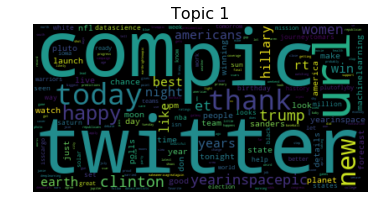

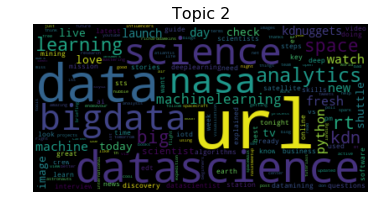

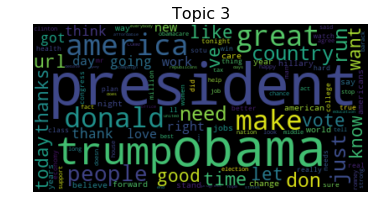

In [16]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

%matplotlib inline

def draw_wordcloud(dict, topic_number):
    wc = WordCloud(max_words=1000)    
    wordcloud = WordCloud().generate_from_frequencies(dict)
    
    plt.title('Topic %s' %str(topic_number), size = 16)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")        
    plt.show()

draw_wordcloud(dict(mywords_topic1), topic_number=1)
draw_wordcloud(dict(mywords_topic2), topic_number=2)
draw_wordcloud(dict(mywords_topic3), topic_number=3)

In [17]:
x = mydata["text"]
y = mydata["author"]

In [18]:
#Vectorize Reviews

vocab = CountVectorizer(analyzer=clean_text).fit(x)
x = vocab.transform(x)
x

<20000x143 sparse matrix of type '<class 'numpy.int64'>'
	with 477065 stored elements in Compressed Sparse Row format>

In [19]:
# Splitting into Test & Train data
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=24)

In [20]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(x_train,y_train)
predmnb = mnb.predict(x_test)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:",classification_report(y_test,predmnb))

Confusion Matrix for Multinomial Naive Bayes:
[[ 23   4  54  29   2  31  26  15   9   2  23]
 [  2 119  58  38   3   2  57   1   4   4  12]
 [ 17  32 483  16   3  52  71  49   5   9  37]
 [  3  12  40 286   2   5  52   8   0   2  32]
 [  5  24  22  30  12   1  16   9   6   1  11]
 [ 15   2  78  34   1 263  31   9   8   2   9]
 [ 10  24 130 149   2  34 361  25   1  13  30]
 [  4   9  76   5   3   5  39 107   0   7  17]
 [  6   1   6   8   0   6   3   1  22   1   1]
 [  4   5  62   3   2   0  23   7   0   7   1]
 [  1   1  28  54   1   7  53   7   1   1 303]]
Score: 49.65
Classification Report:                  precision    recall  f1-score   support

     AdamSavage       0.26      0.11      0.15       218
    BarackObama       0.51      0.40      0.45       300
    DonaldTrump       0.47      0.62      0.53       774
FiveThirtyEight       0.44      0.65      0.52       442
 HillaryClinton       0.39      0.09      0.14       137
  KimKardashian       0.65      0.58      0.61       452


In [21]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr.fit(x_train,y_train)
predrmfr = rmfr.predict(x_test)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,predrmfr))
print("Score:",round(accuracy_score(y_test,predrmfr)*100,2))
print("Classification Report:",classification_report(y_test,predrmfr))

C:\Users\carly\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Confusion Matrix for Random Forest Classifier:
[[ 34  14  57  13   3  29  39  11   1   2  15]
 [  8 146  50  26   8   5  42   8   1   0   6]
 [ 16  28 556  11   3  43  74  26   1   1  15]
 [  5  20  26 283   1   7  71   0   0   0  29]
 [ 20  27  24  12  17   5  15  10   2   0   5]
 [ 24   4  76  15   0 299  19   5   2   0   8]
 [ 11  36 145  68   4  48 432   7   1   3  24]
 [ 12  13  96   3   3   5  38  96   0   1   5]
 [ 12   4   9   3   2  10   5   3   5   0   2]
 [  2  12  55   3   1   3  28   5   0   4   1]
 [  8   3  20  44   1  23  39   7   0   0 312]]
Score: 54.6
Classification Report:                  precision    recall  f1-score   support

     AdamSavage       0.22      0.16      0.18       218
    BarackObama       0.48      0.49      0.48       300
    DonaldTrump       0.50      0.72      0.59       774
FiveThirtyEight       0.59      0.64      0.61       442
 HillaryClinton       0.40      0.12      0.19       137
  KimKardashian       0.63      0.66      0.64       452


In [22]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
preddt = dt.predict(x_test)
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test,preddt))
print("Score:",round(accuracy_score(y_test,preddt)*100,2))
print("Classification Report:",classification_report(y_test,preddt))

Confusion Matrix for Decision Tree:
[[ 42  13  44   9  13  26  28  21   3   5  14]
 [ 11 128  29  26  22   3  42   5   5  18  11]
 [ 35  26 412  19  14  46 110  57  10  25  20]
 [  8  25  22 231   8   8  82   5   2   6  45]
 [ 14  23  12   8  42   1  16  13   3   3   2]
 [ 28  10  65   9   4 252  31  19   7   6  21]
 [ 23  41  94  55  14  40 404  30  10  16  52]
 [ 18  18  46   4  11  10  31 109   3  11  11]
 [ 11   2   8   1   2   4   8   3  13   1   2]
 [  1  16  22   4   3   5  24  17   3  15   4]
 [ 11   9  15  30   3  20  43  14   2   2 308]]
Score: 48.9
Classification Report:                  precision    recall  f1-score   support

     AdamSavage       0.21      0.19      0.20       218
    BarackObama       0.41      0.43      0.42       300
    DonaldTrump       0.54      0.53      0.53       774
FiveThirtyEight       0.58      0.52      0.55       442
 HillaryClinton       0.31      0.31      0.31       137
  KimKardashian       0.61      0.56      0.58       452
           

In [23]:
# Support Vector Machine
from sklearn.svm import SVC
svm = SVC(random_state=101)
svm.fit(x_train,y_train)
predsvm = svm.predict(x_test)
print("Confusion Matrix for Support Vector Machines:")
print(confusion_matrix(y_test,predsvm))
print("Score:",round(accuracy_score(y_test,predsvm)*100,2))
print("Classification Report:",classification_report(y_test,predsvm))

C:\Users\carly\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Confusion Matrix for Support Vector Machines:
[[ 30   6  64  13   2  45  37  11   1   0   9]
 [  2 118  70  20   2   9  60   4   1   0  14]
 [  3  22 557   6   1  55  97  15   1   0  17]
 [  2   8  34 246   0   9 103   2   0   0  38]
 [  9  15  43  11  10  14  20  10   1   0   4]
 [  7   3  63   7   1 335  25   5   0   0   6]
 [  2  11 102  44   3  35 548  11   1   0  22]
 [  4   6  95   3   1   6  39 113   0   0   5]
 [  4   4   9   1   1  10   8   3  13   0   2]
 [  1   7  65   4   0   2  31   2   0   0   2]
 [  3   1  16  21   0  16  47   0   0   0 353]]
Score: 58.08
Classification Report:                  precision    recall  f1-score   support

     AdamSavage       0.45      0.14      0.21       218
    BarackObama       0.59      0.39      0.47       300
    DonaldTrump       0.50      0.72      0.59       774
FiveThirtyEight       0.65      0.56      0.60       442
 HillaryClinton       0.48      0.07      0.13       137
  KimKardashian       0.62      0.74      0.68       452


C:\Users\carly\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\carly\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\carly\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
"""# parameter evaluation
gbe = GradientBoostingClassifier(random_state=0)
parameters = {
     'learning_rate': [0.05, 0.1, 0.5],
    'max_features': [0.5, 1],
    'max_depth': [3, 4, 5]}
gridsearch=GridSearchCV(gbe,parameters,cv=100,scoring='roc_auc')
gridsearch.fit(x,y)
print(gridsearch.best_params_)
print(gridsearch.best_score_)"""
#Boosting
gbi = GradientBoostingClassifier(learning_rate=0.1,max_depth=5,max_features=0.5,random_state=999999)
gbi.fit(x_train,y_train)
predgbi = gbi.predict(x_test)
print("Confusion Matrix for Gradient Boosting Classifier:")
print(confusion_matrix(y_test,predgbi))
print("Score:",round(accuracy_score(y_test,predgbi)*100,2))
print("Classification Report:",classification_report(y_test,predgbi))

Confusion Matrix for Gradient Boosting Classifier:
[[ 46   8  52   4   5  38  36  17   3   0   9]
 [  9 148  34  36  13   2  42   6   4   1   5]
 [  9  15 573   8   6  35  79  27   1   4  17]
 [  1  19  22 313   0   6  55   1   0   1  24]
 [ 16  24  17   7  42   5  12   9   1   0   4]
 [ 13   1  44   5   0 344  23   6   2   0  14]
 [  9  19  75  49   1  38 550  11   0   1  26]
 [ 10   1  79   2   2   2  34 135   0   1   6]
 [  9   1   5   1   4   6   5   5  18   0   1]
 [  2   7  50   2   1   1  28   8   0  13   2]
 [  3   2   9  25   0  11  34   7   0   0 366]]
Score: 63.7
Classification Report:                  precision    recall  f1-score   support

     AdamSavage       0.36      0.21      0.27       218
    BarackObama       0.60      0.49      0.54       300
    DonaldTrump       0.60      0.74      0.66       774
FiveThirtyEight       0.69      0.71      0.70       442
 HillaryClinton       0.57      0.31      0.40       137
  KimKardashian       0.70      0.76      0.73       

In [25]:
# K Nearest Neighbour Algorithm
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train,y_train)
predknn = knn.predict(x_test)
print("Confusion Matrix for K Neighbors Classifier:")
print(confusion_matrix(y_test,predknn))
print("Score: ",round(accuracy_score(y_test,predknn)*100,2))
print("Classification Report:")
print(classification_report(y_test,predknn))

Confusion Matrix for K Neighbors Classifier:
[[ 18  14  62  32   2  32  35   2   0   1  20]
 [  5  79  74  28   2   6  74   4   0   2  26]
 [ 13  72 449  28   4  45 113  11   0   2  37]
 [  8  17  30 230   1   6  94   1   0   0  55]
 [  6  22  40  26   1   9  23   4   0   0   6]
 [ 20   8 110  19   2 227  40   1   0   0  25]
 [  4  35 113  81   2  27 459   7   0   0  51]
 [  4  26 100   9   3   8  54  56   0   0  12]
 [  2   9  10  15   0   3  10   0   3   0   3]
 [  3  12  52   5   0   3  32   3   0   2   2]
 [  3   6  21  35   1  17  53   0   0   0 321]]
Score:  46.12
Classification Report:
                 precision    recall  f1-score   support

     AdamSavage       0.21      0.08      0.12       218
    BarackObama       0.26      0.26      0.26       300
    DonaldTrump       0.42      0.58      0.49       774
FiveThirtyEight       0.45      0.52      0.48       442
 HillaryClinton       0.06      0.01      0.01       137
  KimKardashian       0.59      0.50      0.54       452


In [26]:
# MULTILAYER PERCEPTRON CLASSIFIER
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train,y_train)
predmlp = mlp.predict(x_test)
print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(y_test,predmlp))
print("Score:",round(accuracy_score(y_test,predmlp)*100,2))
print("Classification Report:")
print(classification_report(y_test,predmlp))

Confusion Matrix for Multilayer Perceptron Classifier:
[[ 44  11  44   6  12  27  33  16   5   3  17]
 [  1 170  39  31  14   1  22   4   7   0  11]
 [ 12  32 555   8  15  31  69  24   3   3  22]
 [  0  33  24 285   4   3  48   3   0   4  38]
 [  8  27  19   7  49   2   9  13   1   1   1]
 [ 15   3  64   6   3 304  31   5   2   2  17]
 [ 10  35  92  50  10  31 488  19   1   3  40]
 [  6  12  65   3   6   5  21 136   1   3  14]
 [  6   6   8   1   4   3   6   2  19   0   0]
 [  4  14  47   7   3   3  18   7   1   9   1]
 [  5   1  11  20   3   8  24   3   0   2 380]]
Score: 60.98
Classification Report:
                 precision    recall  f1-score   support

     AdamSavage       0.40      0.20      0.27       218
    BarackObama       0.49      0.57      0.53       300
    DonaldTrump       0.57      0.72      0.64       774
FiveThirtyEight       0.67      0.64      0.66       442
 HillaryClinton       0.40      0.36      0.38       137
  KimKardashian       0.73      0.67      0.70  

C:\Users\carly\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [27]:
### Choose the model with the most balanced and highest values of precision, recall, and f-1 score. WHy?

### Pretty easy modeling, right? Each model can easily be copied and pasted into any other model with similar variable types

In [28]:
#### Now, fill in the string below to see who it predicts the text to be.

In [29]:
nr = "" 
print(nr)
nr_t = vocab.transform([nr])
print("Predicted Rating:",rmfr.predict(nr_t)[0])


Predicted Rating: various
